In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/'

In [ ]:
import os
import numpy as np
import torch
import glob
import time
import torch.nn as nn
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import copy

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1195 Acc: 0.9643


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.0720 Acc: 0.9871

Epoch 1/24
----------
train Loss: 0.1401 Acc: 0.9635
val Loss: 0.0818 Acc: 0.9769

Epoch 2/24
----------
train Loss: 0.1332 Acc: 0.9627
val Loss: 0.0743 Acc: 0.9846

Epoch 3/24
----------
train Loss: 0.1384 Acc: 0.9635
val Loss: 0.0733 Acc: 0.9794

Epoch 4/24
----------
train Loss: 0.1192 Acc: 0.9650
val Loss: 0.0852 Acc: 0.9769

Epoch 5/24
----------
train Loss: 0.1280 Acc: 0.9643
val Loss: 0.0706 Acc: 0.9871

Epoch 6/24
----------
train Loss: 0.0991 Acc: 0.9759
val Loss: 0.0751 Acc: 0.9820

Epoch 7/24
----------
train Loss: 0.1176 Acc: 0.9689
val Loss: 0.0767 Acc: 0.9846

Epoch 8/24
----------
train Loss: 0.1169 Acc: 0.9666
val Loss: 0.0736 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.1334 Acc: 0.9635
val Loss: 0.0720 Acc: 0.9846

Epoch 10/24
----------
train Loss: 0.1240 Acc: 0.9681
val Loss: 0.0798 Acc: 0.9769

Epoch 11/24
----------
train Loss: 0.1087 Acc: 0.9674
val Loss: 0.0769 Acc: 0.9820

Epoch 12/24
----------
train Loss: 0.1234 Acc: 0.9666
v

tensor([[ 58.,   0.,   0.,   0.,   0.,   2.],
        [  0.,  90.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  68.,   0.,   0.,   0.],
        [  0.,   0.,   0., 100.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  46.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  48.]])
tensor([0.9667, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Text(0.5, 69.0, 'Predicted label')

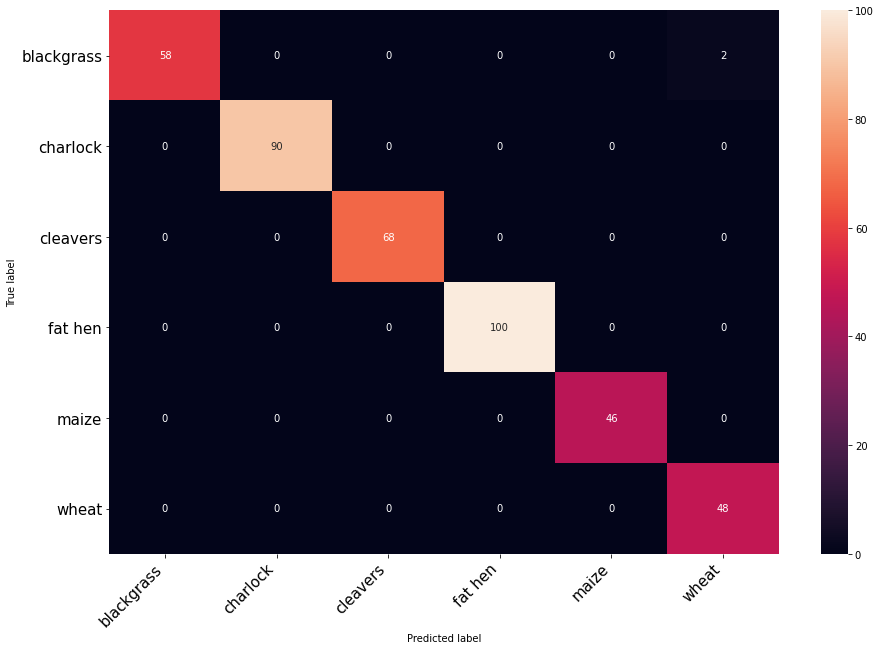

In [ ]:
confusion_matrix = torch.zeros(6, 6)
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_conv(images)
        _, pred = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')